Import Libraries

In [319]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder,OneHotEncoder ,StandardScaler , RobustScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score , confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier

Load and Explore Dataset

In [320]:
healthcare_df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [321]:
healthcare_df.head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


In [322]:
# check null values
healthcare_df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Fill Missing values

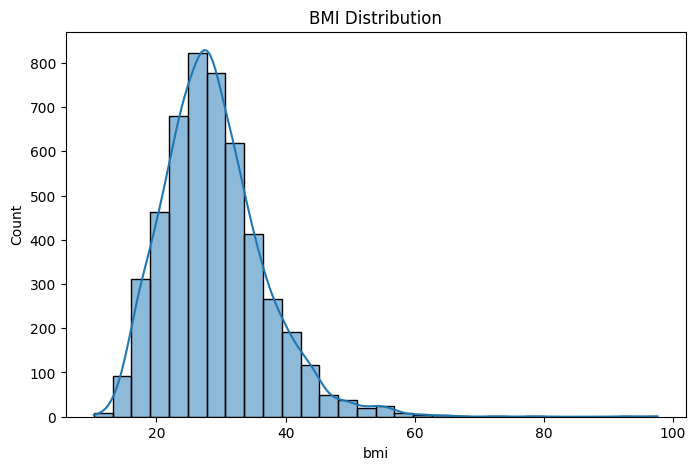

In [323]:
# show distribution for bmi -> Positive distribution
plt.figure(figsize=(8,5))
sns.histplot(healthcare_df , x='bmi' , bins=30 , kde=True)
plt.xlabel("bmi")
plt.ylabel("Count")
plt.title("BMI Distribution")
plt.show()

In [324]:
# bmi(Body Mass Index) -> numerical values [mean - median - mode] impute
impute = SimpleImputer(missing_values=np.nan ,strategy='median')

In [325]:
healthcare_df['bmi'] = impute.fit_transform(healthcare_df[['bmi']])

In [326]:
# check null values after impute
healthcare_df.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [327]:
# check duplicates
print(f'Duplicates in dataset = {healthcare_df.duplicated().sum()}')

Duplicates in dataset = 0


Explore Dataset

In [328]:
healthcare_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [329]:
healthcare_df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.862035,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.699562,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.800000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,32.800000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Preprocessing

In [330]:
numeric_cols = ['age', 'avg_glucose_level', 'bmi']

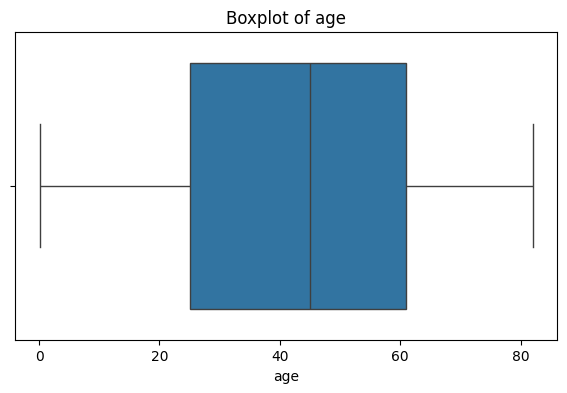

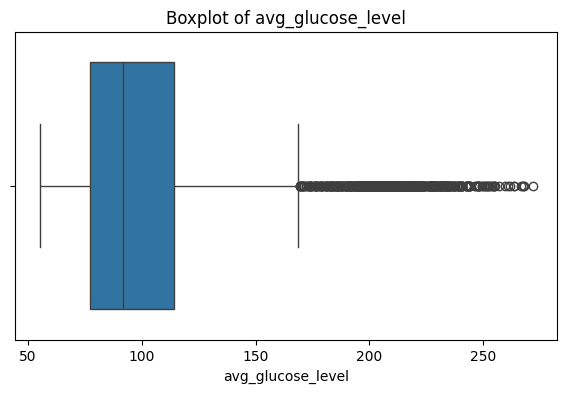

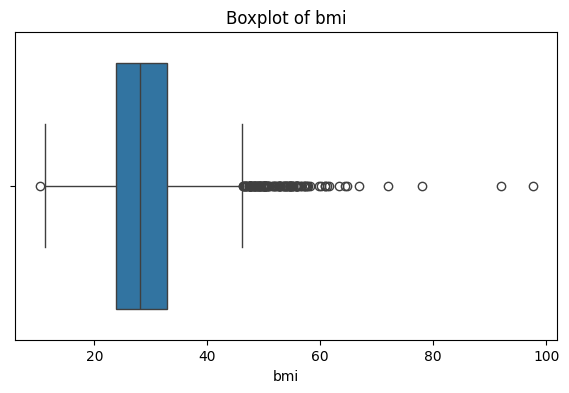

In [331]:
# check outlier
for col in numeric_cols:
    plt.figure(figsize=(7,4))
    sns.boxplot(x=healthcare_df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

In [332]:
#  Detect columns with outliers 
columns_with_outliers = []
for col in numeric_cols:
    Q1 = healthcare_df[col].quantile(0.25)
    Q3 = healthcare_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = healthcare_df[(healthcare_df[col] < lower) | (healthcare_df[col] > upper)]
    if len(outliers) > 0:
        columns_with_outliers.append(col)
        print(f"{col} has {len(outliers)} outliers")
    else:
        print(f"{col} has no outliers")

age has no outliers
avg_glucose_level has 627 outliers
bmi has 126 outliers


In [333]:
for col in columns_with_outliers:
    Q1 = healthcare_df[col].quantile(0.25)
    Q3 = healthcare_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    healthcare_df[col] = healthcare_df[col].clip(lower, upper)

In [334]:
scaler = RobustScaler()
for col in columns_with_outliers:
    healthcare_df[f'{col}_scaled'] = scaler.fit_transform(healthcare_df[[col]])

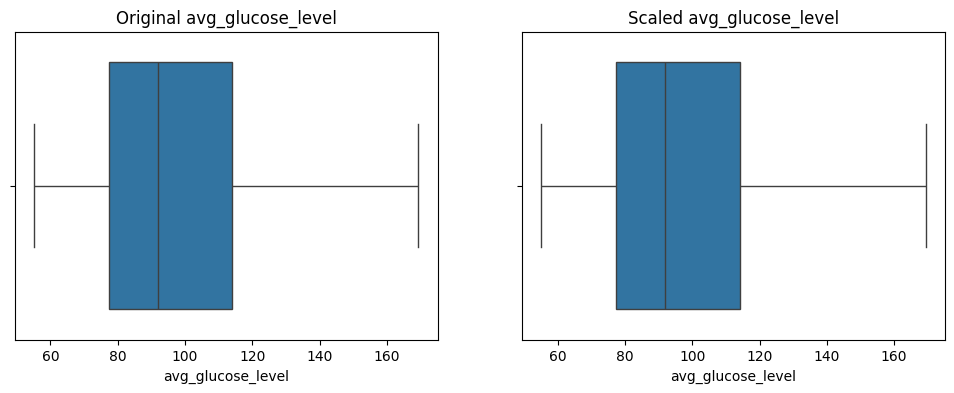

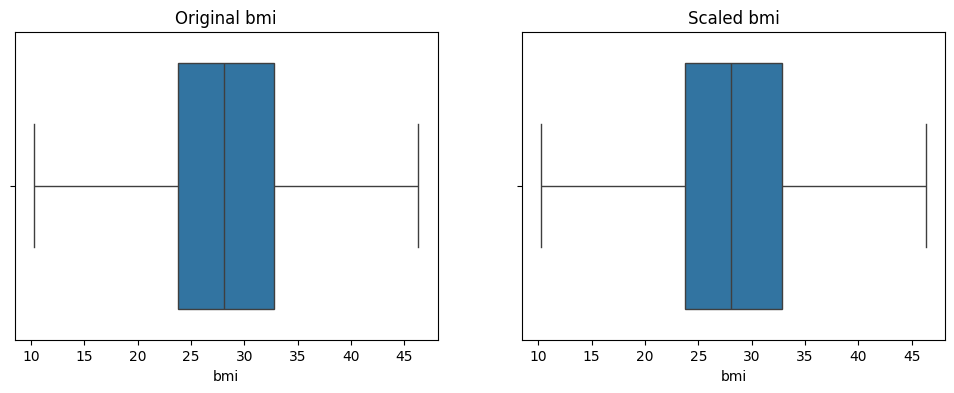

In [335]:
# check outliers after handle
for col in columns_with_outliers:
    plt.figure(figsize=(12,4))
    
    plt.subplot(1,2,1)
    sns.boxplot(x=healthcare_df[col])
    plt.title(f'Original {col}')
    
    plt.subplot(1,2,2)
    sns.boxplot(x=healthcare_df[f'{col}'])
    plt.title(f'Scaled {col}')
    
    plt.show()

In [336]:
# extract catg values
catg_cols = healthcare_df.select_dtypes(object).columns.to_list()

catg_cols

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [337]:
# ['gender', 'ever_married', 'Residence_type'] -> Label Encoder
# ['work_type' , 'smoking_status'] -> One Hot Encode

In [338]:
# Label Encoder 
l_encoder = {}
for col in ['gender', 'ever_married', 'Residence_type']:
    le = LabelEncoder()
    healthcare_df[col] = le.fit_transform(healthcare_df[col])
    l_encoder[col] = le

In [339]:
# OneHot Encoder 
ohe = {}
ohe['work_type'] = OneHotEncoder(drop='first' , handle_unknown= 'ignore' , sparse_output= False)
ohe['smoking_status'] = OneHotEncoder(drop='first' , handle_unknown= 'ignore' , sparse_output= False)

In [340]:
work_type_encoded = ohe['work_type'].fit_transform(healthcare_df[['work_type']])
smoke_encoded = ohe['smoking_status'].fit_transform(healthcare_df[['smoking_status']])

work_type_df = pd.DataFrame(work_type_encoded, columns=ohe['work_type'].get_feature_names_out(['work_type']), index=healthcare_df.index)
smoke_df = pd.DataFrame(smoke_encoded, columns=ohe['smoking_status'].get_feature_names_out(['smoking_status']), index=healthcare_df.index)

encoded_df = pd.concat([work_type_df, smoke_df], axis=1)

In [341]:
healthcare_encoded_df = pd.concat([healthcare_df , encoded_df] , axis=1)

In [342]:
healthcare_encoded_df = healthcare_encoded_df.drop(columns= ['smoking_status' , 'work_type', 'avg_glucose_level_scaled', 'bmi_scaled'] , axis=1)

In [343]:
healthcare_encoded_df

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,1,67.0,0,1,1,1,169.3575,36.6,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,51676,0,61.0,0,0,1,0,169.3575,28.1,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,31112,1,80.0,0,1,1,0,105.9200,32.5,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,60182,0,49.0,0,0,1,1,169.3575,34.4,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1665,0,79.0,1,0,1,0,169.3575,24.0,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,0,80.0,1,0,1,1,83.7500,28.1,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5106,44873,0,81.0,0,0,1,1,125.2000,40.0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5107,19723,0,35.0,0,0,1,0,82.9900,30.6,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5108,37544,1,51.0,0,0,1,0,166.2900,25.6,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


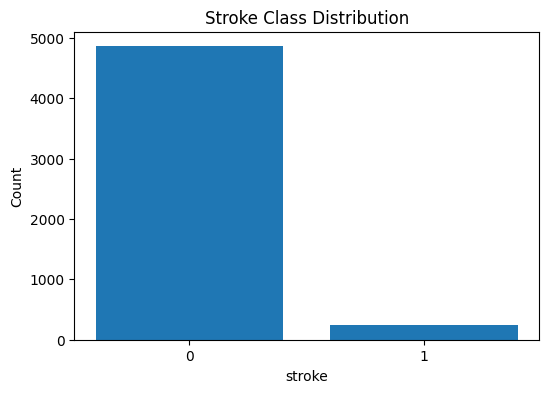

In [344]:
# check if imbalanced dataset or not
counts = healthcare_encoded_df['stroke'].value_counts()

plt.figure(figsize=(6,4))
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel("stroke")
plt.ylabel("Count")
plt.title("Stroke Class Distribution")
plt.show()

Features and Label split

In [345]:
selected_features = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'smoking_status_formerly smoked'
    , 'smoking_status_never smoked','smoking_status_smokes']

In [346]:
X = healthcare_encoded_df[selected_features]
y = healthcare_encoded_df[['stroke']]

In [347]:
X

,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,169.3575,36.6,1.0,0.0,0.0
1,61.0,0,0,169.3575,28.1,0.0,1.0,0.0
2,80.0,0,1,105.9200,32.5,0.0,1.0,0.0
3,49.0,0,0,169.3575,34.4,0.0,0.0,1.0
4,79.0,1,0,169.3575,24.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
5105,80.0,1,0,83.7500,28.1,0.0,1.0,0.0
5106,81.0,0,0,125.2000,40.0,0.0,1.0,0.0
5107,35.0,0,0,82.9900,30.6,0.0,1.0,0.0
5108,51.0,0,0,166.2900,25.6,1.0,0.0,0.0


In [348]:
y

,stroke
0,1
1,1
2,1
3,1
4,1
...,...
5105,0
5106,0
5107,0
5108,0


In [349]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

In [350]:
# declare smote(Synthetic Minority Oversampling Technique)
sm = SMOTE(random_state=50)

In [351]:
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [352]:
# scale 3 columns -> ['age' , 'avg_glucose_level' , 'bmi']
scaler = StandardScaler()

In [353]:
X_test_scaled = X_test.copy()

In [354]:
cols_to_scale = ['age', 'avg_glucose_level', 'bmi']

In [355]:
X_train_res[cols_to_scale] = scaler.fit_transform(X_train_res[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

Create KNeighborsClassifier model

In [356]:
knn = KNeighborsClassifier(n_neighbors= 8)

In [357]:
knn.fit(X_train_res , y_train_res)

c:\Users\Bassam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


,n_neighbors,8
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [358]:
knn_pred = knn.predict(X_test_scaled)

In [359]:
# Evaluate model 
accuracy = accuracy_score(y_test, knn_pred)
print(f"Accuracy Score: {accuracy * 100:.2f}%")

Accuracy Score: 85.42%


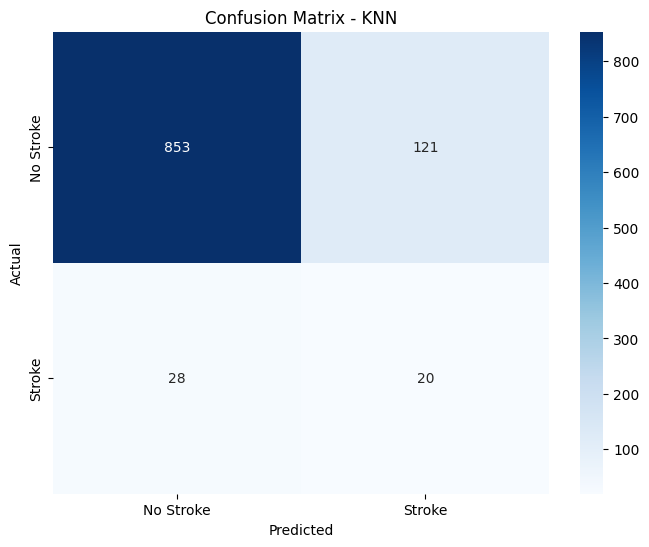

In [360]:
# Visualize Confusion Matrix
conf_matrix = confusion_matrix(y_test, knn_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'])
plt.title('Confusion Matrix - KNN')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

User Input

In [361]:
def predict_stroke():
    print("\n" + "="*60)
    print("STROKE RISK PREDICTION SYSTEM")
    print("="*60)
    print("\nPlease enter the following patient information:\n")

    # -----------------------------
    # Collect ALL User Inputs
    # -----------------------------
    
    # Gender
    while True:
        gender = input("Gender (Male/Female): ").strip().capitalize()
        if gender in ['Male', 'Female']:
            break
        print("Invalid input! Please enter 'Male' or 'Female'")

    # Age
    while True:
        try:
            age = float(input("Age: "))
            if 0 <= age <= 120:
                break
            print("Invalid age! Please enter a value between 0 and 120")
        except ValueError:
            print("Invalid input! Please enter a numeric value")

    # Hypertension
    while True:
        hypertension = input("Hypertension (0=No, 1=Yes): ").strip()
        if hypertension in ['0', '1']:
            hypertension = int(hypertension)
            break
        print("Invalid input! Please enter 0 or 1")

    # Heart Disease
    while True:
        heart_disease = input("Heart Disease (0=No, 1=Yes): ").strip()
        if heart_disease in ['0', '1']:
            heart_disease = int(heart_disease)
            break
        print("Invalid input! Please enter 0 or 1")

    # Ever Married
    while True:
        ever_married = input("Ever Married (Yes/No): ").strip().capitalize()
        if ever_married in ['Yes', 'No']:
            break
        print("Invalid input! Please enter 'Yes' or 'No'")

    # Work Type
    while True:
        work_type = input("Work Type (Private/Self-employed/Govt_job/children/Never_worked): ").strip()
        if work_type in ['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked']:
            break
        print("Invalid input!")

    # Residence Type
    while True:
        residence_type = input("Residence Type (Urban/Rural): ").strip().capitalize()
        if residence_type in ['Urban', 'Rural']:
            break
        print("Invalid input! Please enter 'Urban' or 'Rural'")

    # Average Glucose Level
    while True:
        try:
            avg_glucose_level = float(input("Average Glucose Level: "))
            if 0 <= avg_glucose_level <= 500:
                break
            print("Invalid glucose level!")
        except ValueError:
            print("Invalid input! Please enter a numeric value")

    # BMI
    while True:
        try:
            bmi = float(input("BMI (Body Mass Index): "))
            if 0 <= bmi <= 100:
                break
            print("Invalid BMI!")
        except ValueError:
            print("Invalid input! Please enter a numeric value")

    # Smoking Status
    while True:
        smoking_status = input("Smoking Status (never smoked/formerly smoked/smokes): ").strip().lower()
        if smoking_status in ['never smoked', 'formerly smoked', 'smokes']:
            break
        print("Invalid input! Please enter 'never smoked', 'formerly smoked', or 'smokes'")

    # -----------------------------------
    # Store ALL user data (for records)
    # -----------------------------------
    user_full_data = {
        'gender': gender,
        'age': age,
        'hypertension': hypertension,
        'heart_disease': heart_disease,
        'ever_married': ever_married,
        'work_type': work_type,
        'Residence_type': residence_type,
        'avg_glucose_level': avg_glucose_level,
        'bmi': bmi,
        'smoking_status': smoking_status
    }

    # -----------------------------------
    # Display Entered Data
    # -----------------------------------
    print("\n" + "="*60)
    print("PATIENT INFORMATION SUMMARY")
    print("="*60)
    print(f"Gender:                 {gender}")
    print(f"Age:                    {age}")
    print(f"Hypertension:           {'Yes' if hypertension == 1 else 'No'}")
    print(f"Heart Disease:          {'Yes' if heart_disease == 1 else 'No'}")
    print(f"Ever Married:           {ever_married}")
    print(f"Work Type:              {work_type}")
    print(f"Residence Type:         {residence_type}")
    print(f"Average Glucose Level:  {avg_glucose_level}")
    print(f"BMI:                    {bmi}")
    print(f"Smoking Status:         {smoking_status.title()}")
    print("="*60)

    # -----------------------------------
    # Create DataFrame with ONLY Selected Features for Prediction
    # -----------------------------------
    user_data = pd.DataFrame({
        'age': [age],
        'hypertension': [hypertension],
        'heart_disease': [heart_disease],
        'avg_glucose_level': [avg_glucose_level],
        'bmi': [bmi],
        'smoking_status_formerly smoked': [1 if smoking_status == 'formerly smoked' else 0],
        'smoking_status_never smoked': [1 if smoking_status == 'never smoked' else 0],
        'smoking_status_smokes': [1 if smoking_status == 'smokes' else 0]
    })

    # -----------------------------------
    # Scaling numerical features
    # -----------------------------------
    user_data[['age', 'avg_glucose_level', 'bmi']] = scaler.transform(
        user_data[['age', 'avg_glucose_level', 'bmi']]
    )

    # -----------------------------------
    # Ensure correct column order (same as training)
    # -----------------------------------
    user_data = user_data[selected_features]

    # -----------------------------------
    # Prediction
    # -----------------------------------
    prediction = knn.predict(user_data)[0]

    print("\n" + "="*60)
    print("PREDICTION RESULT:")
    print("="*60)
    if prediction == 1:
        print("⚠️  HIGH RISK → Stroke Detected")
        print("\nRecommendation: Please consult a healthcare professional immediately.")
    else:
        print("✓  LOW RISK → No Stroke")
        print("\nRecommendation: Maintain a healthy lifestyle and regular checkups.")
    print("="*60)

    return prediction, user_full_data

In [362]:
predction1 = predict_stroke()


STROKE RISK PREDICTION SYSTEM

Please enter the following patient information:


PATIENT INFORMATION SUMMARY
Gender:                 Male
Age:                    25.0
Hypertension:           No
Heart Disease:          No
Ever Married:           No
Work Type:              Private
Residence Type:         Urban
Average Glucose Level:  85.0
BMI:                    22.0
Smoking Status:         Never Smoked

PREDICTION RESULT:
✓  LOW RISK → No Stroke

Recommendation: Maintain a healthy lifestyle and regular checkups.


In [364]:
predction2 = predict_stroke()


STROKE RISK PREDICTION SYSTEM

Please enter the following patient information:


PATIENT INFORMATION SUMMARY
Gender:                 Female
Age:                    69.0
Hypertension:           Yes
Heart Disease:          Yes
Ever Married:           Yes
Work Type:              Never_worked
Residence Type:         Rural
Average Glucose Level:  300.0
BMI:                    39.0
Smoking Status:         Formerly Smoked

PREDICTION RESULT:
⚠️  HIGH RISK → Stroke Detected

Recommendation: Please consult a healthcare professional immediately.
